In [2]:
from glob import glob
import os

from monai.transforms import(
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
    RandAffined,
    RandRotated,
    RandGaussianNoised,
)

import numpy as np
import nibabel as nib

from monai.utils import first

from monai.data import Dataset, DataLoader

In [3]:
data_dir = 'D:/GraduateWorkData/nifti_files2/22vs8'

train_images = sorted(glob(os.path.join(data_dir, 'TrainImages', '*.nii.gz')))
train_labels = sorted(glob(os.path.join(data_dir, 'TrainLabels', '*.nii.gz')))

val_images = sorted(glob(os.path.join(data_dir, 'TestImages', '*.nii.gz')))
val_labels = sorted(glob(os.path.join(data_dir, 'TestLabels', '*.nii.gz')))

train_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(train_images, train_labels)]
val_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(val_images, val_labels)]

In [5]:
generate_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True,), 
        RandAffined(keys=['image', 'label'], prob=0.5, translate_range=10), 
        RandRotated(keys=['image', 'label'], prob=0.5, range_x=10.0),
        RandGaussianNoised(keys='image', prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)

In [35]:
generat_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),

        RandAffined(keys=['image', 'label'], prob=0.5, translate_range=10), 
        RandRotated(keys=['image', 'label'], prob=0.5, range_x=10.0),
        RandGaussianNoised(keys='image', prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)

In [6]:
def save_nifti(in_image, in_label, out, index = 0):
    # Convert the torch tensors into numpy array
    volume = np.array(in_image.detach().cpu()[0, :, :, :], dtype=np.float32)
    lab = np.array(in_label.detach().cpu()[0, :, :, :], dtype=np.float32)
    
    # Convert the numpy array into nifti file
    volume = nib.Nifti1Image(volume, np.eye(4))
    lab = nib.Nifti1Image(lab, np.eye(4))
    
    # Create the path to save the images and labels
    path_out_images = os.path.join(out, 'Images')
    path_out_labels = os.path.join(out, 'Labels')
    
    # Make directory if not existing
    if not os.path.exists(path_out_images):
        os.mkdir(path_out_images)
    if not os.path.exists(path_out_labels):
        os.mkdir(path_out_labels)
    
    path_data = os.path.join(out, 'Images')
    path_label = os.path.join(out, 'Labels')
    nib.save(volume, os.path.join(path_data, f'patient_generated_{index}.nii.gz'))
    nib.save(lab, os.path.join(path_label, f'patient_generated_{index}.nii.gz'))

    print(f'patient_generated_{index} is saved', end='\r')

In [22]:
output_path = 'D:/GraduateWorkData/nifti_files2/AugmentatedDataWithoutTransform'
number_runs = 10
for i in range(number_runs):
    name_folder = 'generated_data_' + str(i)
    os.mkdir(os.path.join(output_path, name_folder))
    output = os.path.join(output_path, name_folder)
    check_ds = Dataset(data=train_files, transform=generate_transforms)
    check_loader = DataLoader(check_ds, batch_size=1)
    check_data = first(check_loader)
    for index, patient in enumerate(check_loader):
        save_nifti(patient['image'], patient['label'], output, index)
    print(f'step {i} done')

step 0 doneerated_20 is saved
step 1 doneerated_20 is saved
step 2 doneerated_20 is saved
step 3 doneerated_20 is saved
step 4 doneerated_20 is saved
step 5 doneerated_20 is saved
step 6 doneerated_20 is saved
step 7 doneerated_20 is saved
step 8 doneerated_20 is saved
step 9 doneerated_20 is saved


In [36]:
original_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True,), 
        #RandAffined(keys=['image', 'label'], prob=0.5, translate_range=10), 
        #RandRotated(keys=['image', 'label'], prob=0.5, range_x=10.0),
        #RandGaussianNoised(keys='image', prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)

In [37]:
original_ds = Dataset(data=train_files, transform=original_transforms)
original_loader = DataLoader(original_ds, batch_size=1)
original_patient = first(original_loader)

generat_ds = Dataset(data=train_files, transform=generate_transforms)
generat_loader = DataLoader(generat_ds, batch_size=1)
generat_patient = first(generat_loader)

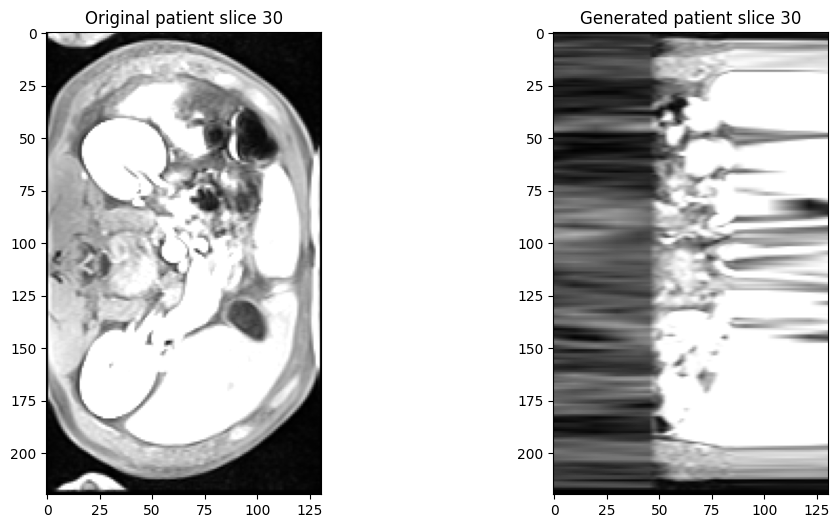

In [40]:
import matplotlib.pyplot as plt
number_slice = 30
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(original_patient["image"][0, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(generat_patient["image"][0, 0, :, :, number_slice], cmap="gray")

In [42]:
from glob import glob
import os
import shutil

#data_folder = 'D:/GraduateWorkData/nifti_files2/AugmentatedDataWithoutTransform'
#out_folder = 'D:/GraduateWorkData/nifti_files2/AugmentatedDataset/TrainImages'
data_folder = 'D:/GraduateWorkData/nifti_files2/AugmentatedDataWithTransform'
out_folder = 'D:/GraduateWorkData/nifti_files2/AugmentatedDatasetWithTransform/TrainImages'

for i, path in enumerate(glob(os.path.normpath(data_folder+'/*'))):
    images_path = os.path.normpath(os.path.join(path, 'Images'))
    labels_path = os.path.normpath(os.path.join(path, 'Labels'))

    for patient in sorted(glob(os.path.normpath(images_path + '/*'))):
        patient_name = os.path.basename(patient)

        shutil.copy(patient, os.path.normpath(os.path.join(out_folder, f'{i}_' + patient_name)))

In [43]:
from glob import glob
import os
import shutil

# data_folder = 'D:/GraduateWorkData/nifti_files2/AugmentatedDataWithoutTransform'
# out_folder = 'D:/GraduateWorkData/nifti_files2/AugmentatedDataset/TrainLabels'
data_folder = 'D:/GraduateWorkData/nifti_files2/AugmentatedDataWithTransform'
out_folder = 'D:/GraduateWorkData/nifti_files2/AugmentatedDatasetWithTransform/TrainLabels'

for i, path in enumerate(glob(os.path.normpath(data_folder+'/*'))):
    images_path = os.path.normpath(os.path.join(path, 'Images'))
    labels_path = os.path.normpath(os.path.join(path, 'Labels'))

    for patient in sorted(glob(os.path.normpath(labels_path + '/*'))):
        patient_name = os.path.basename(patient)

        shutil.copy(patient, os.path.normpath(os.path.join(out_folder, f'{i}_' + patient_name)))